In [6]:
'''
   Author: Anna Bielawska
   Field of study: Mathematics and Statistics
   Dissertation: Compressive sensing - the new sampling method.
   Institution of studies: Wrocław University of Science and Technology
   Year of thesis defence: 2021
   
   The code written below was used for computer simulations included in the diploma thesis.
   It contains 4 original part-implementations of optimization algorithms: Basis Pursuit, Basic Thresholding, 
   Iterative Hard Thresholding, Hard Thresholding Pursuit, with use of scipy library. 
   There already existed an implementation of the 5th algorithm of interest, OMP - Orthogonal Matching Pursuit.
'''

################################################ BASIS PURSUIT ##################################################

def reconstructBP(vec, Mat, tolerance = 1e-16):
    
    '''Basis pursuit algorithm as in the thesis,
       recovers a nearly-sparse vector res from vec and Mat;
       Mat - sampling matrix,
       vec - vector of measurements,
       tolerance - magnitude of error to be tolerated'''
    
    # A function to be minimized, min ||x||_1
    fun = lambda x: sum(abs(x))
           
    # Length of the original signal == number of columns in the matrix Mat
    Z = np.shape(Mat)[1]
    
    # Constraints of the problem
    cons = {'type': 'eq', 'fun': lambda x: Mat.dot(x) - vec}
    
    # Find solution to the optimization problem
    res = scipy.optimize.minimize(fun, x0 = np.ones(Z), method='SLSQP', constraints=cons, tol = tolerance)['x']
    
    return res

############################################### BT - Basic Thresholding ############################################

def Ls(Arr, s, N):
    
    '''A function returning a list of s non-zero largest (in terms of module) indices;
       Arr - an array to be filtered,
       s - a number of non-zero coefficients,
       N - lenght of signal to be reconstructed
    '''
    
    if s > N:
        s = N
    Arr_1 = np.abs(Arr)
    Arr_sorted = sorted(Arr_1, reverse = True)
    
    # Find the boundary coefficient
    threshold = Arr_sorted[s-1]
    
    # Find indices of coefficients to be rid of (zeroed)
    Ls_index_0 = np.where(Arr_1 < threshold)
    
    # Change into a list of indices
    Ls_index_0 = np.concatenate(Ls_index_0).tolist()
    
    return Ls_index_0

def reconstructBT(A, y, s, tolerance = 1e-5):
    
    '''Basic thresholding algorithm as in the thesis,
       recovers a sparse vector res.x from y and A;
       A - sampling matrix,
       y - vector of measurements,
       s - number of non-zero coefficients in the signal to be reconstructed,
       tol = tolerance (error)'''
    
    # A function to be minimized (||Ax - y||_2)^2
    fun = lambda x: sum((A.dot(x) - y)**2)
    
    # Length of original signal
    N = np.shape(A)[1]
    
    # Dictionary for the estimator
    D = Ls(np.transpose(A).dot(y), s, N)

    # Constraints of the problem, x[D] = 0, indices of x that are in D must be equal to 0
    cons = {'type': 'eq', 'fun': lambda x: x[D]}
    
    # Find solution to the minimization problem
    res = scipy.optimize.minimize(fun, x0 = np.zeros(N), method='SLSQP', constraints=cons, tol = tolerance)    
    
    # Return a sparse vector x of the solution
    return res.x

############################################# IHT - Iterative Hard Thresholding ###################################

def hardThreshold(vec, size):
    
    '''A function returning a vector with small coefficients equal to zero;
    vec - vector to be filtered,
    size = number of non-zero coefficients to be left unchanged'''
    
    new_vec = sorted(abs(vec), reverse = True)
    thr = new_vec[size-1]
    
    #np.array of True/False
    j = abs(vec) < thr
    
    #where True, substitute with 0
    vec[j] = 0
    
    return vec


def IHT(A, y, s, Its=200, tol=0.0001):
    
    '''Iterative hard thresholding algorithm as in the thesis,
       recovers a sparse vector xhat from y and A;
       A - sampling matrix,
       y - vector of measurements,
       s - number of non-zero coefficients in the signal to be reconstructed,
       Its - number of maximum algorithm iterations,
       tol = tolerance (error)'''

    # Length of original signal
    Length = np.shape(A)[1]

    # Initial estimate
    xhat = np.zeros(Length)

    for t in range(Its):

        # Pre-threshold value
        gamma = xhat + np.dot(np.transpose(A), y-A.dot(xhat))

        # Estimate the signal (by hard thresholding)
        xhat = hardThreshold(gamma, size=s)

        # Stopping criteria
        if sum(abs(y-A.dot(xhat))) < tol:
            break

    return xhat


############################################ HTP - Hard Thresholding Pursuit ############################################

def HTP(A, y, s, Its=100, tol=0.0001):
    
    '''Hard thresholding pursuit algorithm as in the thesis,
       recovers a sparse vector xhat from y and A;
       A - sampling matrix,
       y - vector of measurements,
       s - number of non-zero coefficients in the signal to be reconstructed,
       Its - number of maximum algorithm iterations,
       tol = tolerance (error)'''

    # A function to be minimized
    fun = lambda x: sum((y - A.dot(x))**2)
    
    # Length of original signal
    N = np.shape(A)[1]

    # Initial estimate
    xhat = np.zeros(N)

    for t in range(Its):
        
        # Pre-threshold value
        gamma = xhat + np.dot(np.transpose(A), y-A.dot(xhat))

        # Find the dictionary in k-th step
        D_k = Ls(gamma, s, N)
        
        # Constraints for the problem
        cons = {'type': 'eq', 'fun': lambda x: x[D_k]}

        sol = scipy.optimize.minimize(fun, x0 = xhat, method='SLSQP', constraints=cons, tol = tol)    
        
        # Estimated solution
        xhat = sol.x

        # Stopping criteria
        if sum(abs(y-A.dot(xhat))) < tol:
            break

    return xhat


In [7]:
def coherence(A, B): 
    
    '''A function computing coherence between two l_2 normed matrices, A and B,
        where A is a rectangular (m times n) matrix and B is a square (n times n) matrix'''
    
    coher = 1
    n = np.shape(B)[1]
    m = np.shape(A)[0]
    for row in range(m):
        theta = A[row, ].reshape(1,n)
        for col in range(n):
            psi = B[:, col].reshape(n,1)
            if np.sqrt(n)*np.abs(theta.dot(psi)) > coher:
                coher = np.sqrt(n)*np.abs(theta.dot(psi))
    return coher

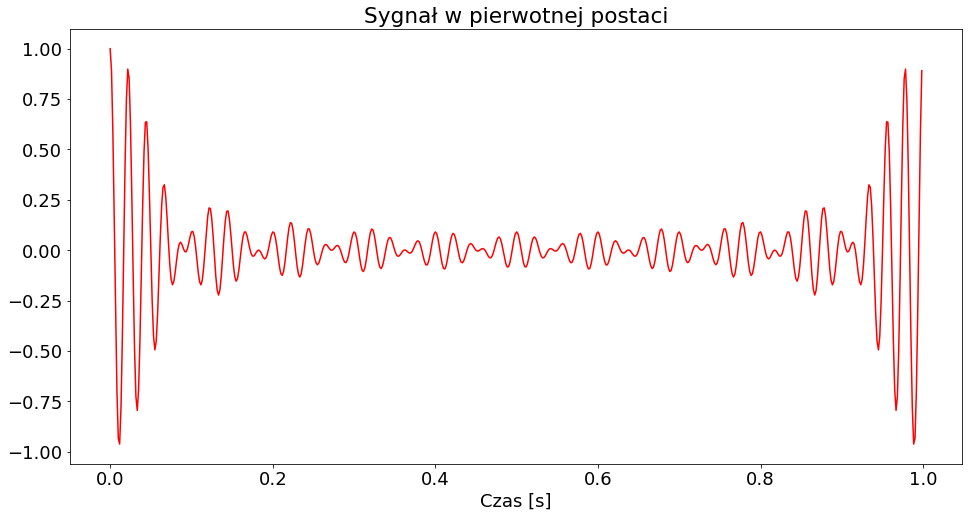

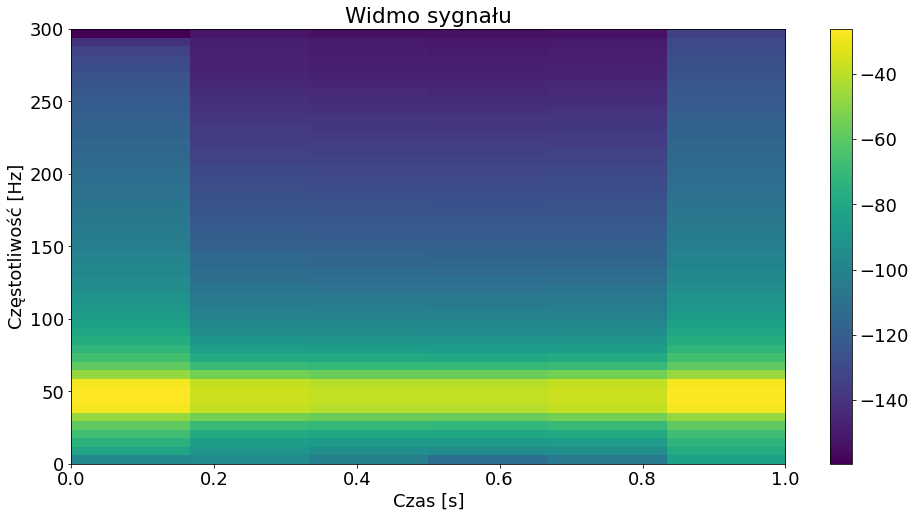

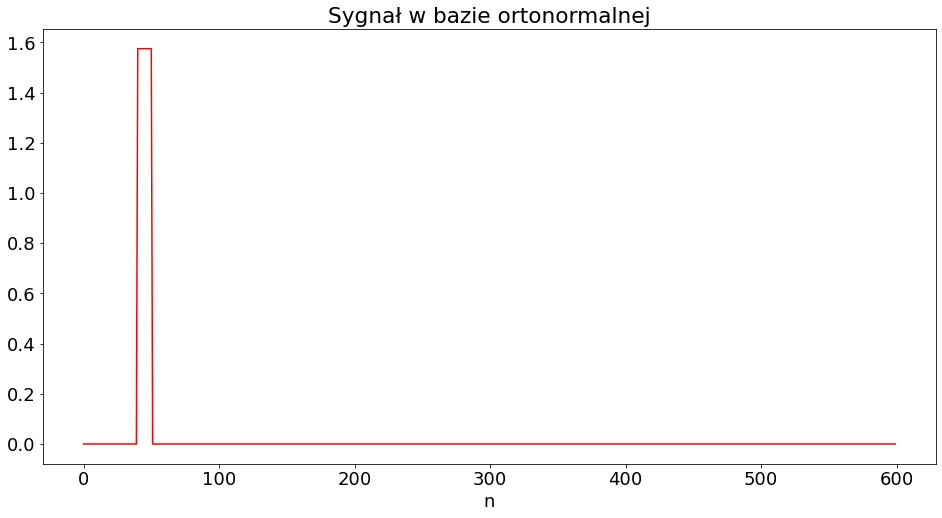

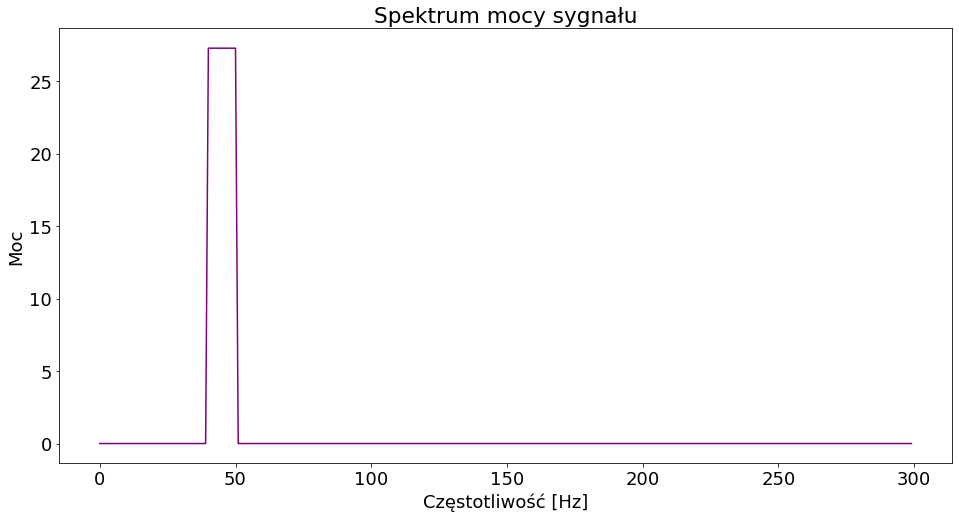

In [8]:
from sklearn.linear_model import orthogonal_mp

import scipy
import numpy as np
from scipy.fft import fft, fftfreq
import sounddevice as sd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import sympy 
import random
import pywt

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams.update({'font.size': 18})
t_1 = 1

#600 Hz sampling
dt = 1/600

t = np.arange(0, t_1, dt)

def signal(x, n):

    '''A function for sparse-signal construction, returns a column vector (array)'''
    
    suma = 0
    for i in range(n):
        suma += 1/11*np.cos(2*np.pi*(i+40)*x)
    return suma

def ONB(x, N):
    
    '''A function for orthonormal basis construction, rows are subsequent vectors of basis, l2 normalized'''
    
    arr = np.zeros(shape=(N, N))
    for n in range(N):
        if n <= N/2:
            arr[n] = np.cos(2*np.pi*x*n)
        else:
            arr[n] = np.sin(2*np.pi*x*n)
    mat = normalize(arr, norm='l2', axis=1)
    return mat

x = signal(t, n=11)

fs = 1/dt

plt.rcParams['figure.figsize'] = (16, 8)
plt.plot(t, x, c='red')
plt.title("Sygnał w pierwotnej postaci")
plt.xlabel('Czas [s]')
plt.show()

Nn = len(t)
B = ONB(x=t, N=Nn)

x_new = B.dot(x)

plt.specgram(x, NFFT=100, Fs=1/dt, noverlap=0)
plt.xlim(0, 1)
plt.title("Widmo sygnału")
plt.xlabel('Czas [s]')
plt.ylabel('Częstotliwość [Hz]')
plt.colorbar()
plt.show()

plt.plot(t*600, x_new, color = "red")
plt.title("Sygnał w bazie ortonormalnej")
plt.xlabel('n')
plt.show()
N = int((1/dt)*t_1)
K = int(np.floor(N/2))


ff = scipy.fft.fft(x)
xff = fftfreq(Nn, dt)
plt.plot(xff[:K], np.abs(ff)[:K], c='purple')
plt.title("Spektrum mocy sygnału")
plt.xlabel('Częstotliwość [Hz]')
plt.ylabel('Moc')
plt.show()

Mm = 140
k = 11

np.random.seed(1019)

A = np.random.normal(0, 1/np.sqrt(Nn), (Mm, Nn))
A_norm = normalize(A, norm='l2', axis=1)
y = A.dot(x_new)

#print("Norma l_1 dla x_new: {}".format(sum(abs(x_new))))

#print("Spójnośc między macierzami: {}".format(float(coherence(A_norm, B.T))))

omp = orthogonal_mp(A, y, tol = 1e-16)

<ipython-input-9-365a42a7d0c2>:16: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


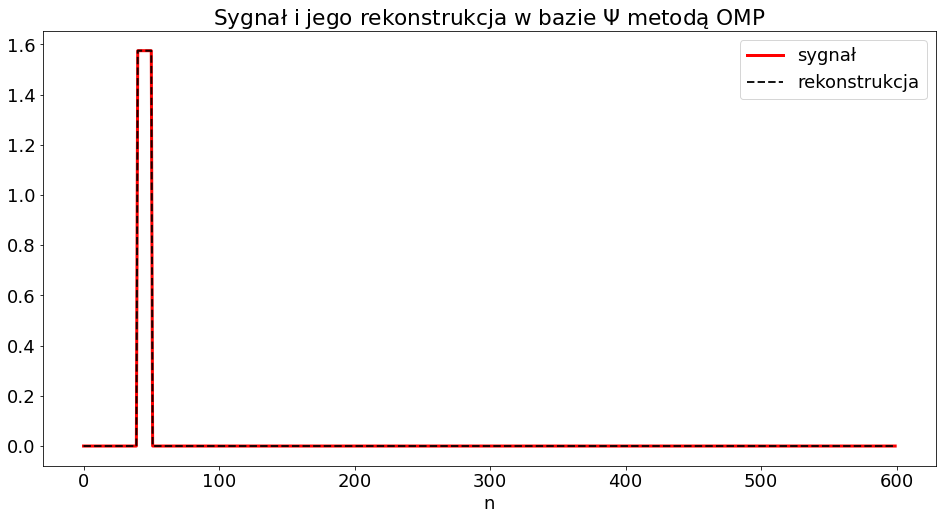

Błąd SSR wynosi: 3.0501048399194484e-26


<ipython-input-9-365a42a7d0c2>:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


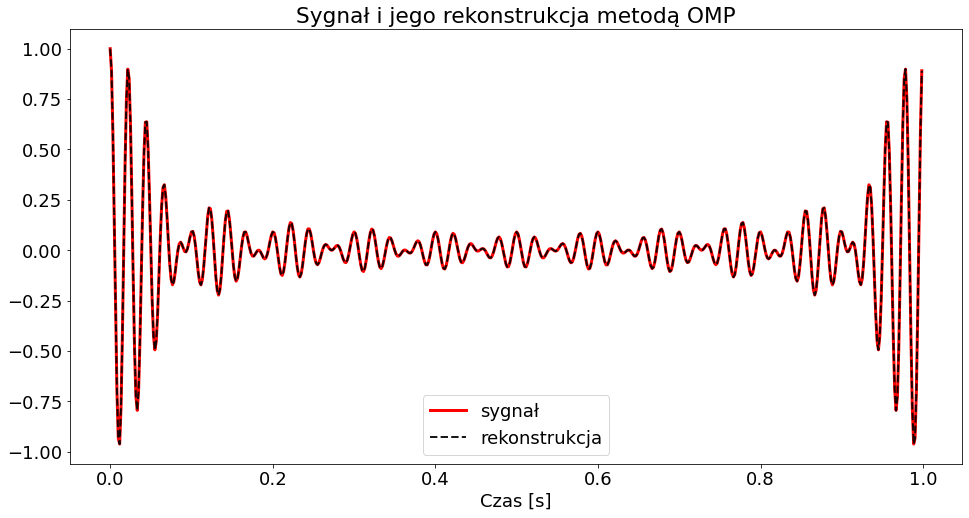

Norma l_1 dla bp: 20.476434857562825


<ipython-input-9-365a42a7d0c2>:41: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


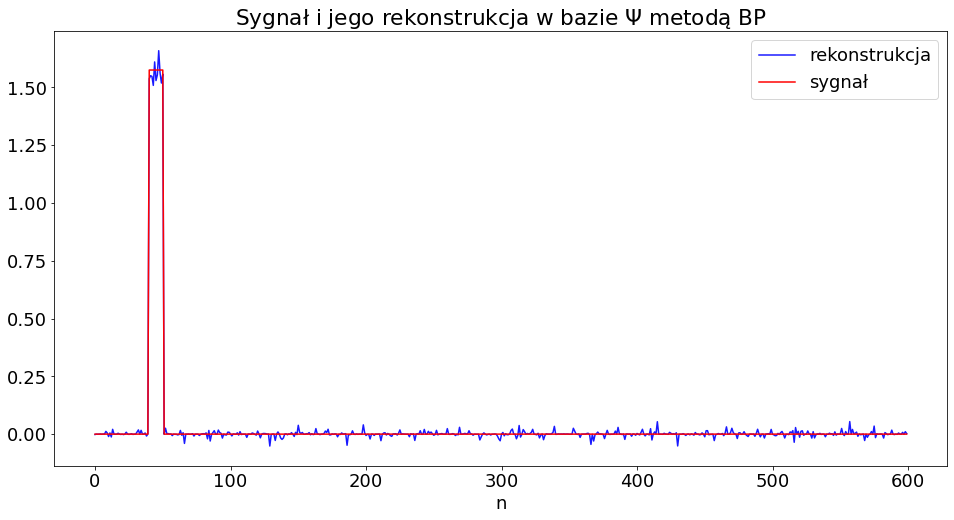

Błąd SSR wynosi: 0.08743265591650114


<ipython-input-9-365a42a7d0c2>:51: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


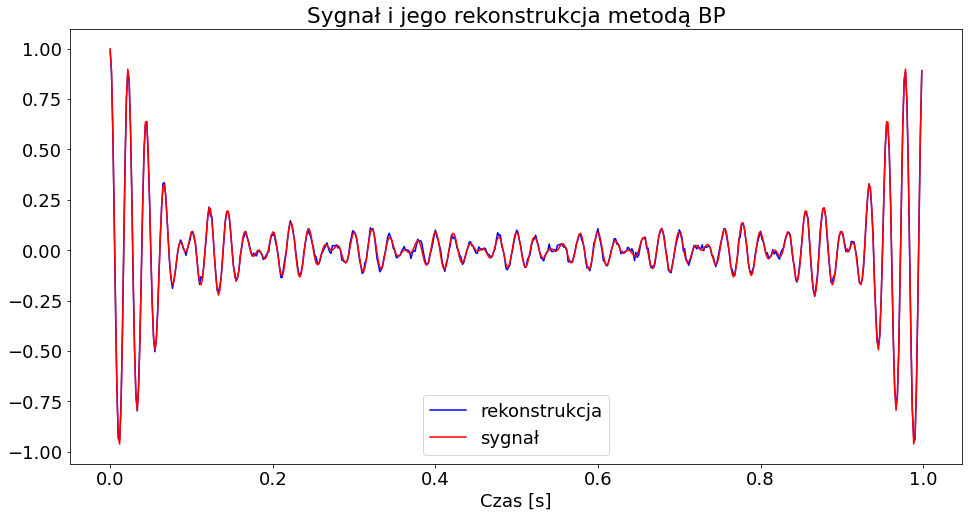

<ipython-input-9-365a42a7d0c2>:64: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


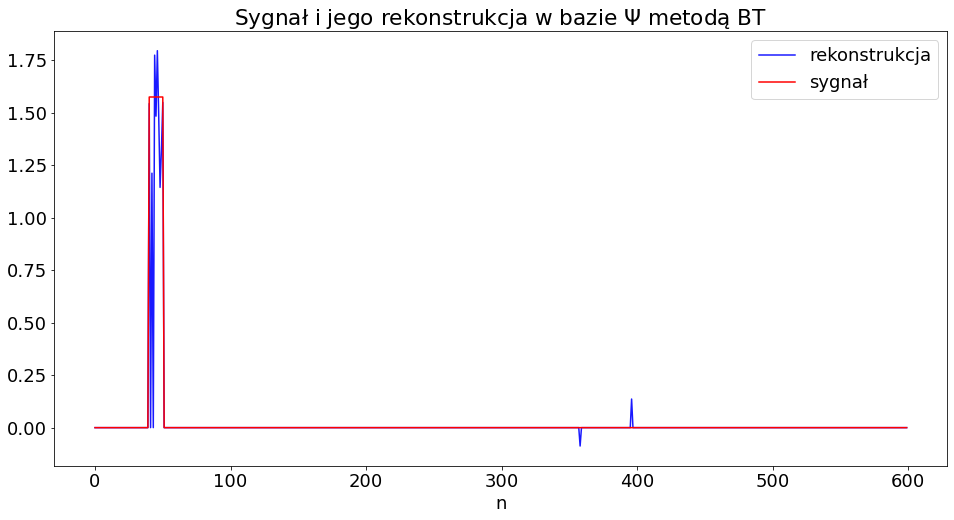

Błąd SSR wynosi: 5.471091379321129


<ipython-input-9-365a42a7d0c2>:75: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


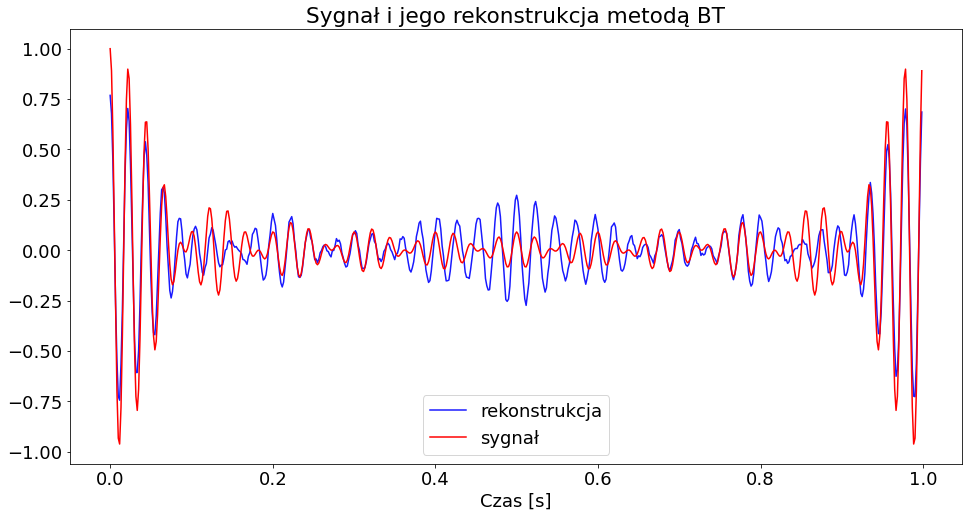

<ipython-input-9-365a42a7d0c2>:90: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


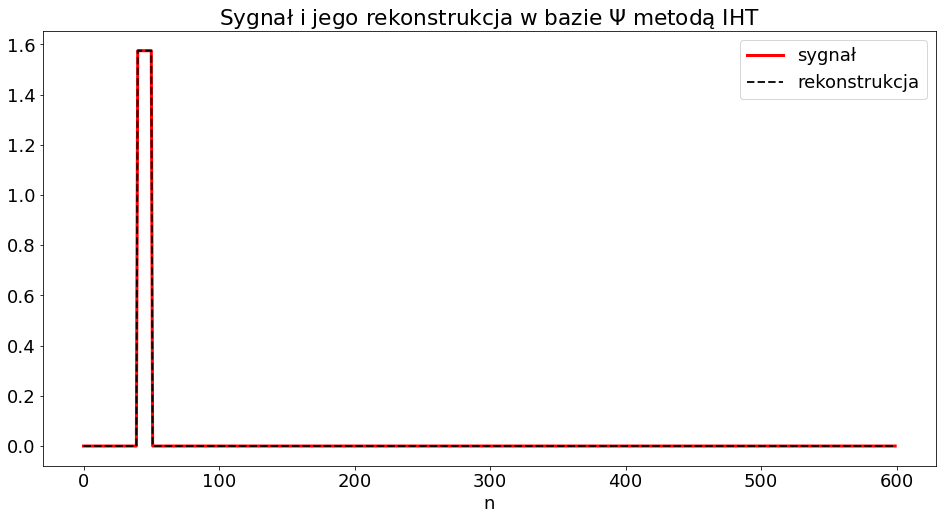

Błąd SSR wynosi: 5.526341584840949e-22


<ipython-input-9-365a42a7d0c2>:100: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


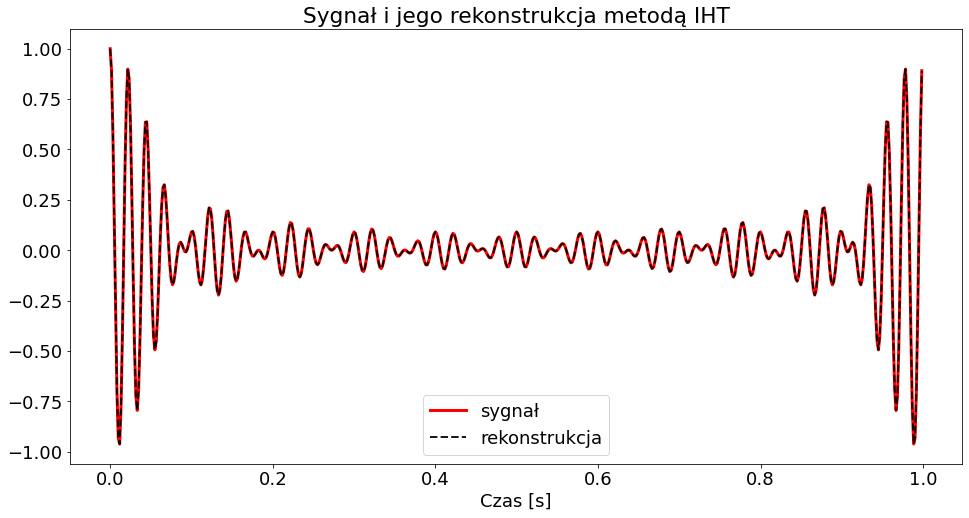

Norma l_1 dla bp: 17.320507985818313


<ipython-input-9-365a42a7d0c2>:112: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


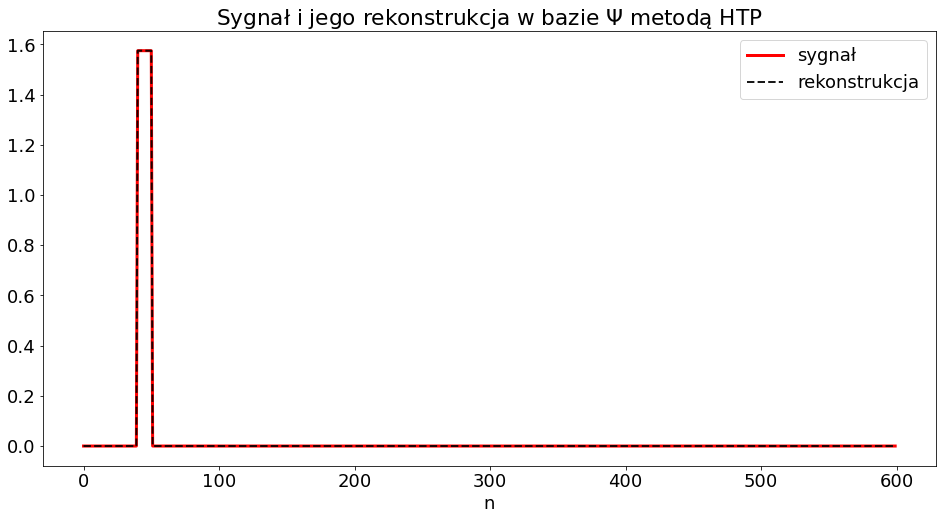

Błąd SSR wynosi: 8.766170563187862e-16


<ipython-input-9-365a42a7d0c2>:122: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


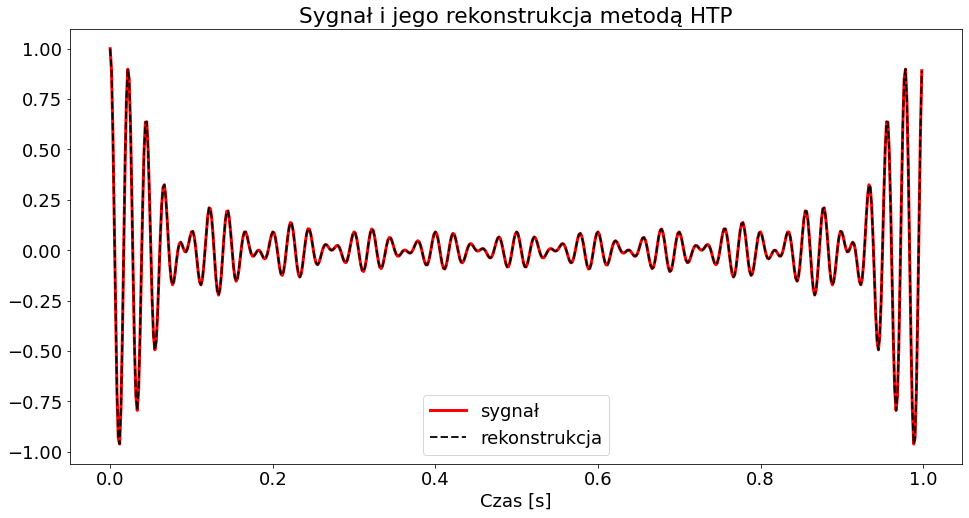

In [9]:
############################################# ALGORYTMY M=140 S=11 ###########################################

################################################ OMP ###################################################

#print("Spójnośc między macierzami: {}".format(float(coherence(A_norm, B))))

coef = orthogonal_mp(A, y, tol=1e-16)


fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t*600, x_new, c='red', linewidth=3)
ax.plot(t*600, coef, c='black', label='x(t)', linewidth=2, linestyle='dashed', alpha = 0.9)
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą OMP")
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

SSR = (x - B.T.dot(coef))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))

plt.plot(t, x, color = "red", linewidth = 3)
plt.plot(t, B.T.dot(coef), color = "black", linewidth=2, linestyle='dashed', alpha = 0.9)
plt.xlabel('Czas [s]')
plt.title("Sygnał i jego rekonstrukcja metodą OMP")
plt.xlabel('Czas [s]')
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

################################################### BP ###############################################

bp = reconstructBP(vec=y, Mat=A, tolerance = 1e-16)
#print("Norma l_1 dla bp: {}".format(sum(abs(bp))))

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t*600, bp, c='blue', label='x(t)', alpha = 0.9)
ax.plot(t*600, x_new, c='red')
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą BP")
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()

SSR = (x - B.T.dot(bp))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))

plt.plot(t, B.T.dot(bp), color = "blue")
plt.plot(t, x, color = "red")
plt.xlabel('Czas [s]')
plt.title("Sygnał i jego rekonstrukcja metodą BP")
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()

################################################## BT ################################################

bt = reconstructBT(A, y, s=k, tolerance = 1e-16)

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t*600, bt, c='blue', label='x(t)', alpha = 0.9)
ax.plot(t*600, x_new, c='red')
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą BT")
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()

SSR = (x - B.T.dot(bt))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))

plt.plot(t, B.T.dot(bt), color = "blue", alpha = 0.9)
plt.plot(t, x, color = "red")
plt.xlabel('Czas [s]')
plt.title("Sygnał i jego rekonstrukcja metodą BT")
plt.xlabel('Czas [s]')
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()

# print(bt.nonzero())

############################################## IHT #################################################

iht = IHT(A, y, s=k, tol = 1e-16)

#print("Norma l_1 dla iht: {}".format(sum(abs(iht))))

plt.plot(t*600, x_new, color = "red", linewidth = 3)
plt.plot(t*600, iht, color = "black", linewidth=2, linestyle='dashed', alpha = 0.9)
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą IHT")
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

SSR = (x - B.T.dot(iht))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))

plt.plot(t, x, color = "red", linewidth = 3)
plt.plot(t, B.T.dot(iht), color = "black", linewidth=2, linestyle='dashed', alpha = 0.9)
plt.title("Sygnał i jego rekonstrukcja metodą IHT")
plt.xlabel('Czas [s]')
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

############################################## HTP ################################################

htp = HTP(A, y, s=k, tol = 1e-16)
print("Norma l_1 dla bp: {}".format(sum(abs(htp))))

plt.plot(t*600, x_new, color = "red", linewidth = 3)
plt.plot(t*600, htp, color = "black", linewidth=2, linestyle='dashed', alpha = 0.9)
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą HTP")
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

SSR = (x - B.T.dot(htp))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))

plt.plot(t, x, color = "red", linewidth = 3)
plt.plot(t, B.T.dot(htp), color = "black", linewidth=2, linestyle='dashed', alpha = 0.9)
plt.title("Sygnał i jego rekonstrukcja metodą HTP")
plt.xlabel('Czas [s]')
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

Norma l_1 dla iht: 17.375195416034007


<ipython-input-10-0bfd0a9d894f>:33: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


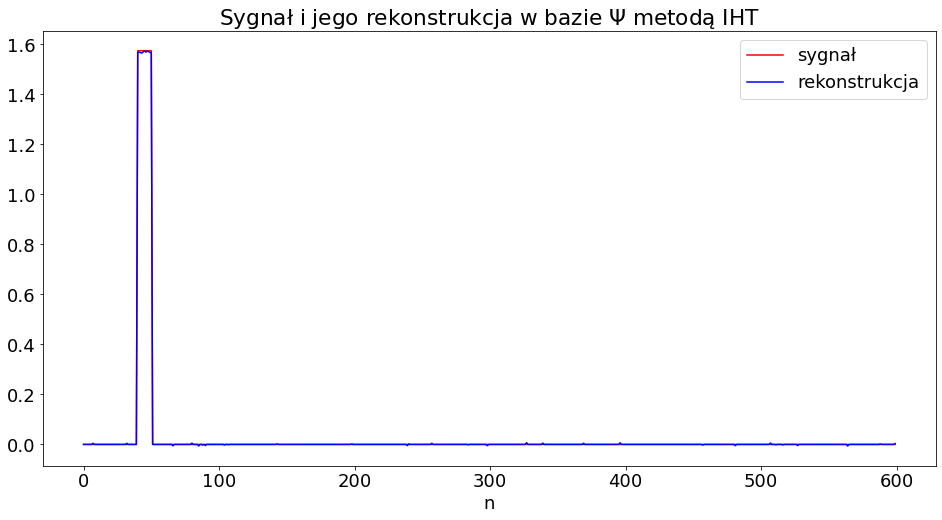

Błąd SSR wynosi: 0.0009434039770928211


<ipython-input-10-0bfd0a9d894f>:45: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


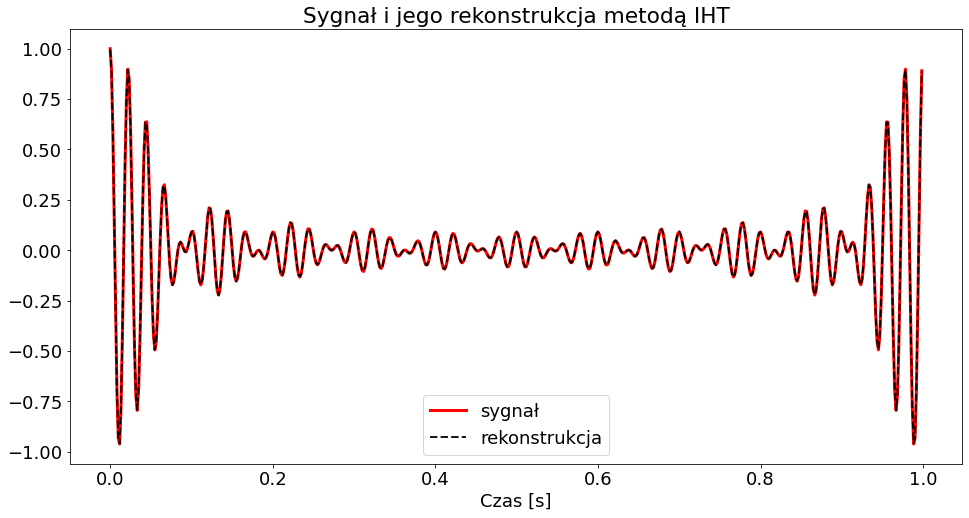

Norma l_1 dla bp: 17.320508256902606


<ipython-input-10-0bfd0a9d894f>:59: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


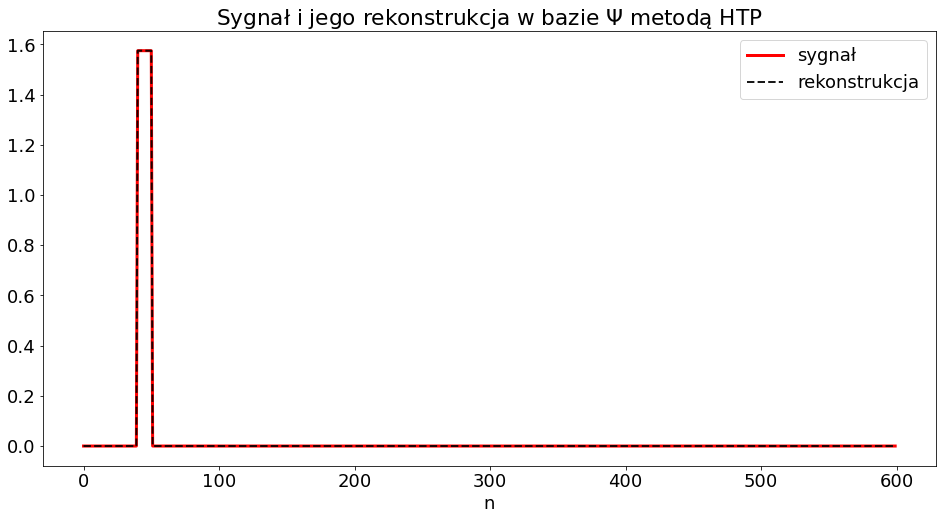

Błąd SSR wynosi: 1.0498415907016997e-14


<ipython-input-10-0bfd0a9d894f>:69: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


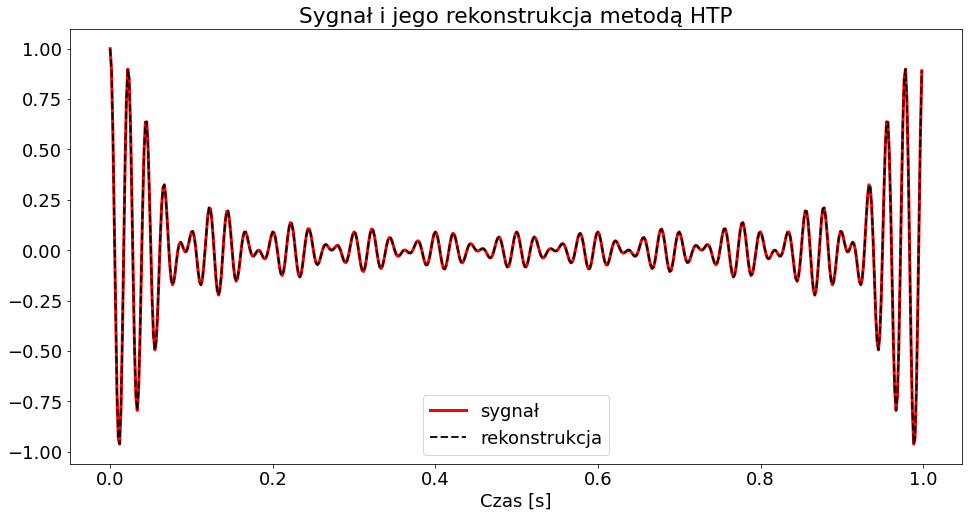

<ipython-input-10-0bfd0a9d894f>:82: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


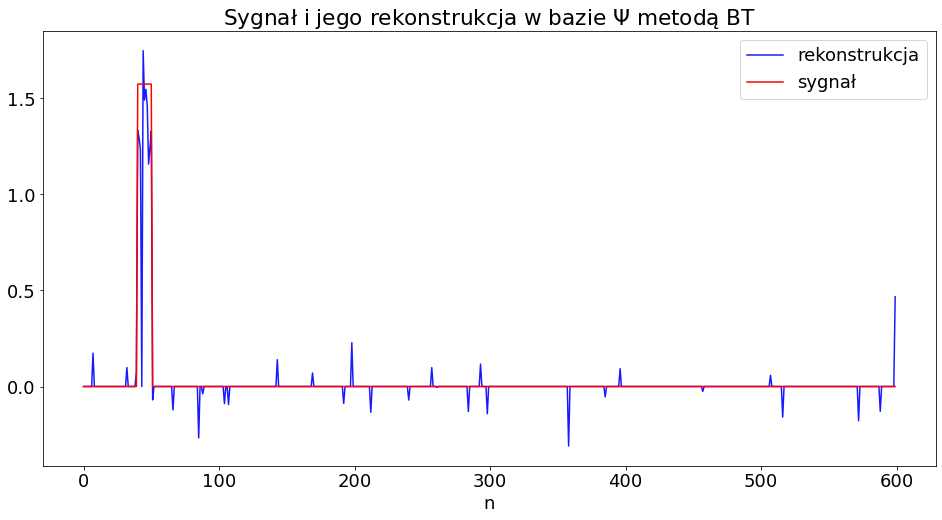

Błąd SSR wynosi: 3.8549864582256292


<ipython-input-10-0bfd0a9d894f>:93: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


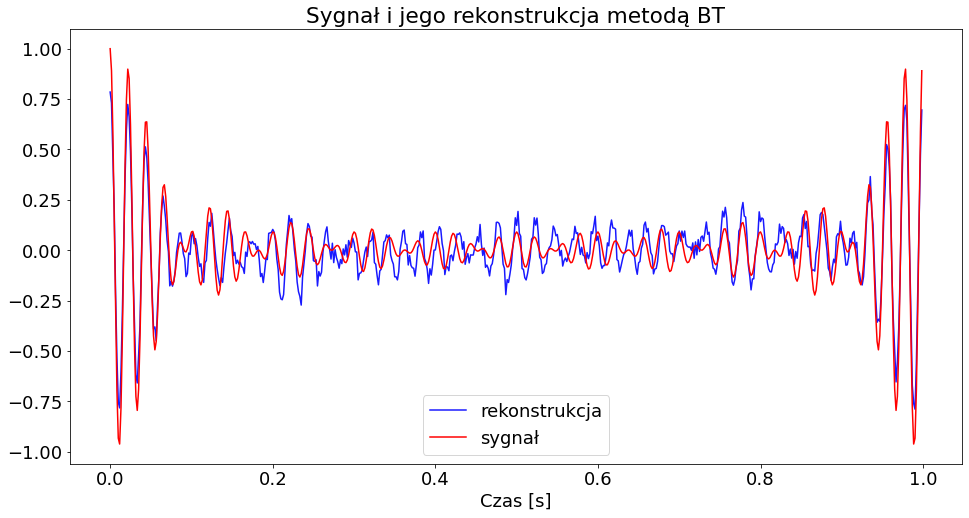

In [10]:
############################################# ALGORYTMY M=140 S=40 ###########################################

plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams.update({'font.size': 18})
t_1 = 1
dt = 1/600
t = np.arange(0, t_1, dt)

x = signal(t, n=11)
Nn = len(t)
B = ONB(x=t, N=Nn)
x_new = B.dot(x)

Mm = 140
k = 40

np.random.seed(1019)
A = np.random.normal(0, 1/np.sqrt(Nn), (Mm, Nn))
y = A.dot(x_new)

############################################# IHT ###########################################

iht = IHT(A, y, s=k, tol = 1e-16)

#print("Norma l_1 dla iht: {}".format(sum(abs(iht))))

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t*600, x_new, c='red', linewidth=1.5)
ax.plot(t*600, iht, c='blue', label='x(t)', alpha = 1)
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą IHT")
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

#print(iht.nonzero())

SSR = (x - B.T.dot(iht))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))

plt.plot(t, x, color = "red", linewidth = 3)
plt.plot(t, B.T.dot(iht), color = "black", linewidth=2, linestyle='dashed', alpha = 0.9)
plt.title("Sygnał i jego rekonstrukcja metodą IHT")
plt.xlabel('Czas [s]')
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

############################################# HTP ###########################################

htp = HTP(A, y, s=k, tol = 1e-16)
#print("Norma l_1 dla bp: {}".format(sum(abs(htp))))

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t*600, x_new, c='red', linewidth=3)
ax.plot(t*600, htp, c='black', label='x(t)', linewidth=2, linestyle='dashed', alpha = 0.9)
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą HTP")
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

SSR = (x - B.T.dot(htp))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))

plt.plot(t, x, color = "red", linewidth = 3)
plt.plot(t, B.T.dot(htp), color = "black", linewidth=2, linestyle='dashed', alpha = 0.9)
plt.xlabel('Czas [s]')
plt.title("Sygnał i jego rekonstrukcja metodą HTP")
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

############################################# BT ###########################################

bt = reconstructBT(A, y, s=k, tolerance = 1e-16)

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t*600, bt, c='blue', label='x(t)', alpha = 0.9)
ax.plot(t*600, x_new, c='red')
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą BT")
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()

SSR = (x - B.T.dot(bt))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))

plt.plot(t, B.T.dot(bt), color = "blue", alpha = 0.9)
plt.plot(t, x, color = "red")
plt.xlabel('Czas [s]')
plt.title("Sygnał i jego rekonstrukcja metodą BT")
plt.xlabel('Czas [s]')
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()

# print(bt.nonzero())

Spójnośc między macierzami: 4.0452093745204705


<ipython-input-12-85755cd12f3a>:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


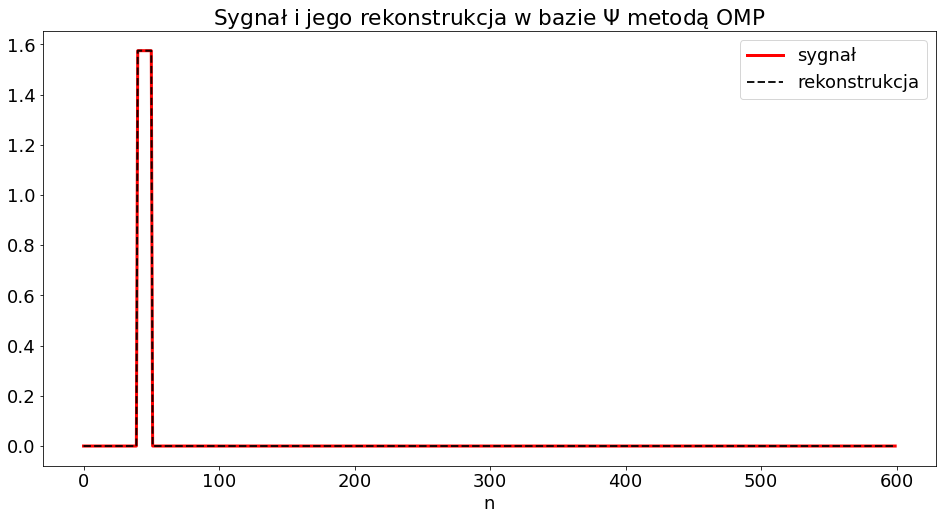

Błąd SSR wynosi: 3.7590512098336155e-26


<ipython-input-12-85755cd12f3a>:51: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


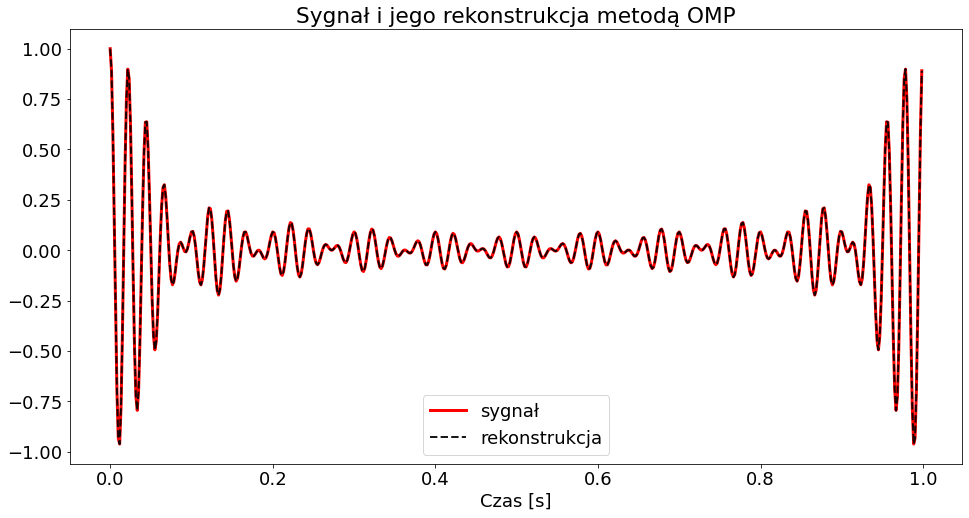

<ipython-input-12-85755cd12f3a>:65: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


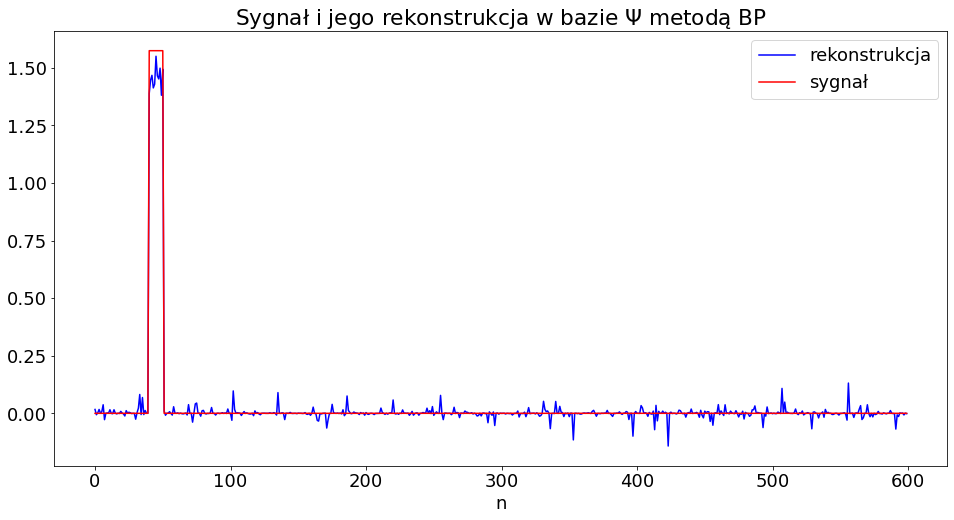

Błąd SSR wynosi: 0.4003497178753665


<ipython-input-12-85755cd12f3a>:76: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


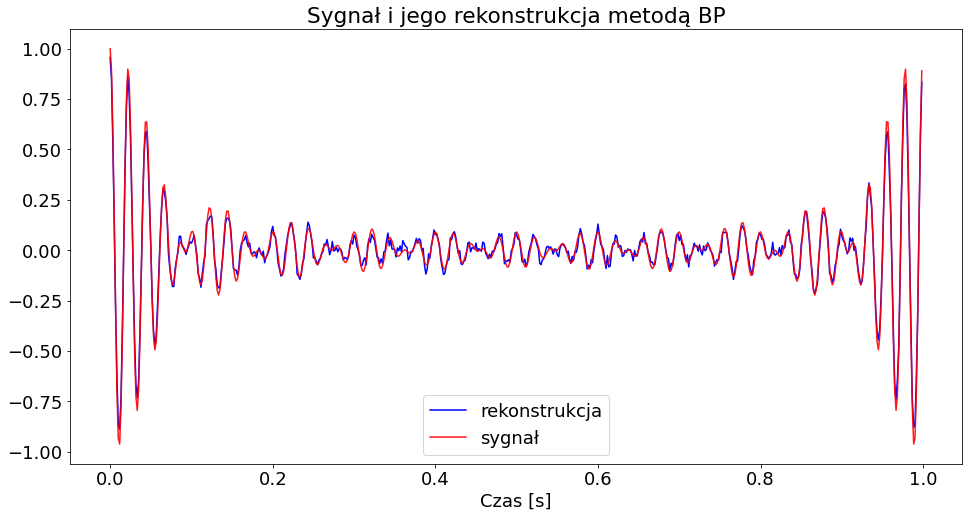

<ipython-input-12-85755cd12f3a>:91: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


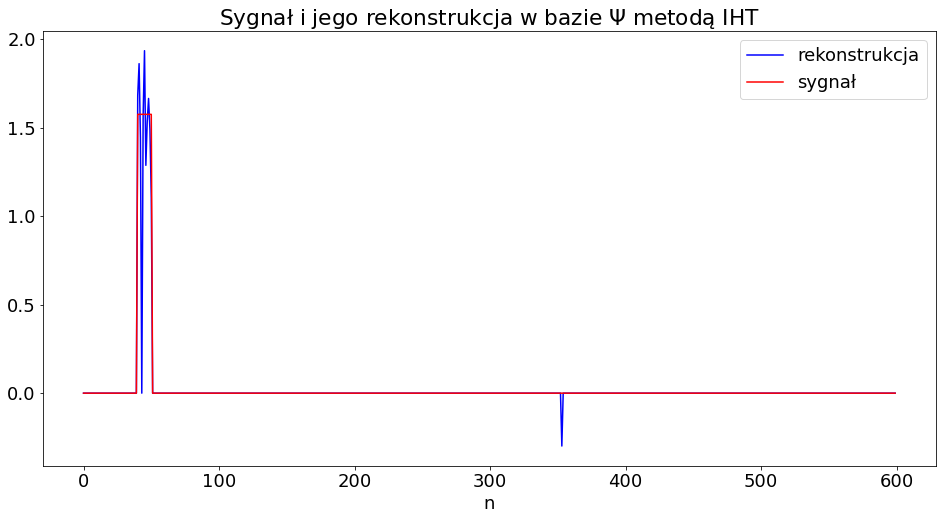

Błąd SSR wynosi: 3.1271502295165914


<ipython-input-12-85755cd12f3a>:103: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


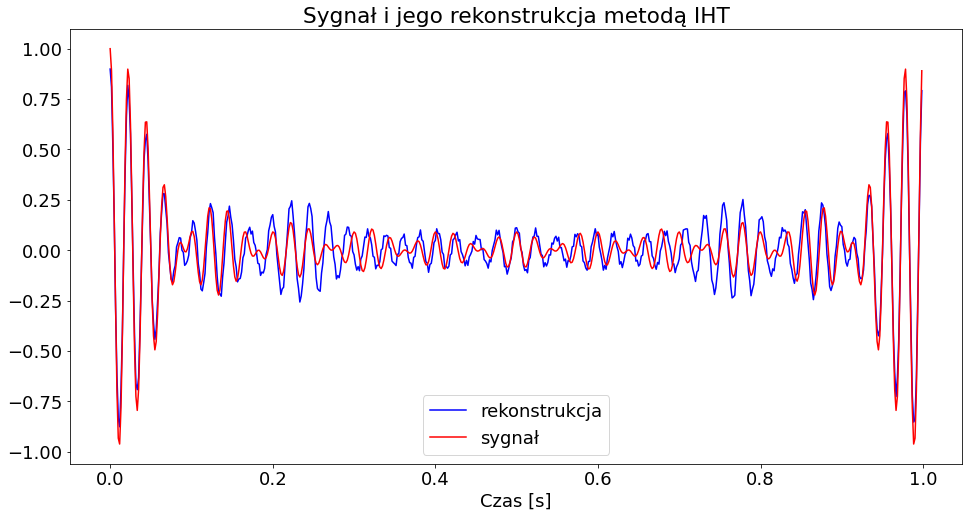

<ipython-input-12-85755cd12f3a>:117: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


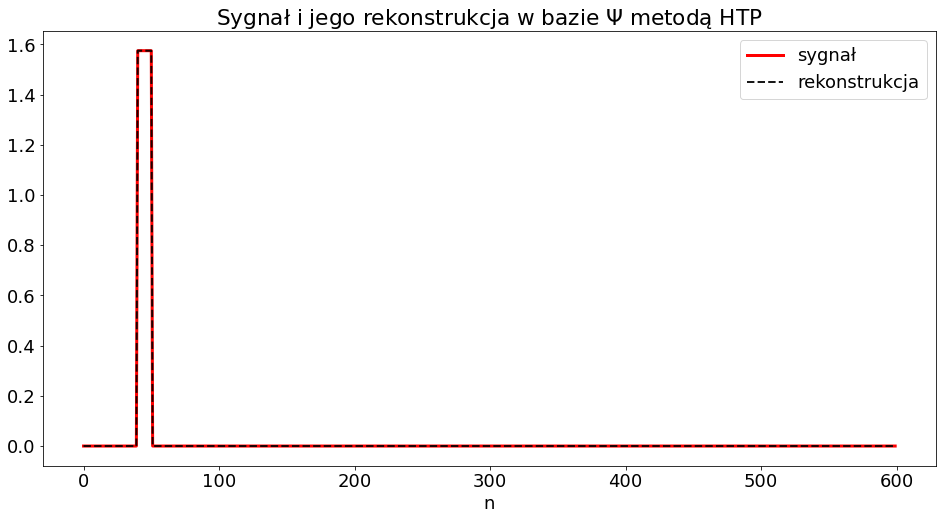

Błąd SSR wynosi: 1.1466436413183005e-15


<ipython-input-12-85755cd12f3a>:127: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


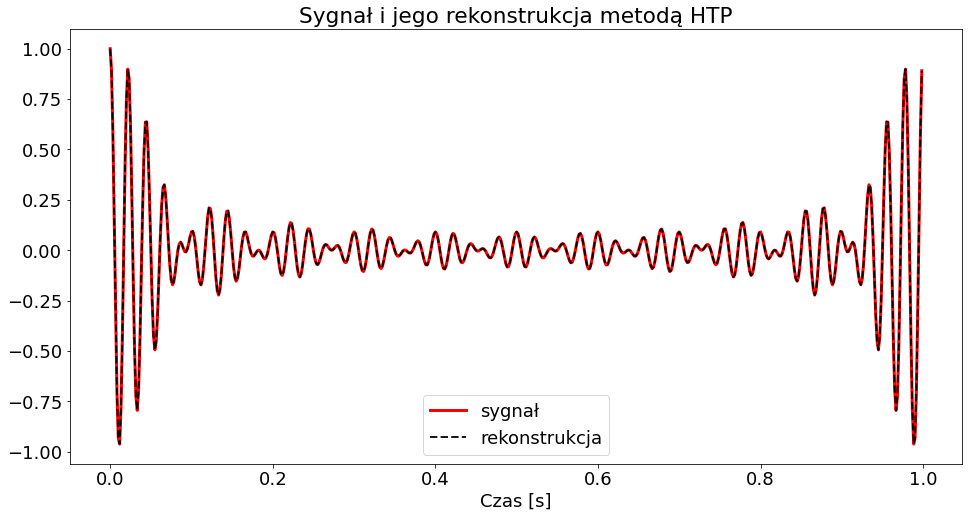

<ipython-input-12-85755cd12f3a>:142: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


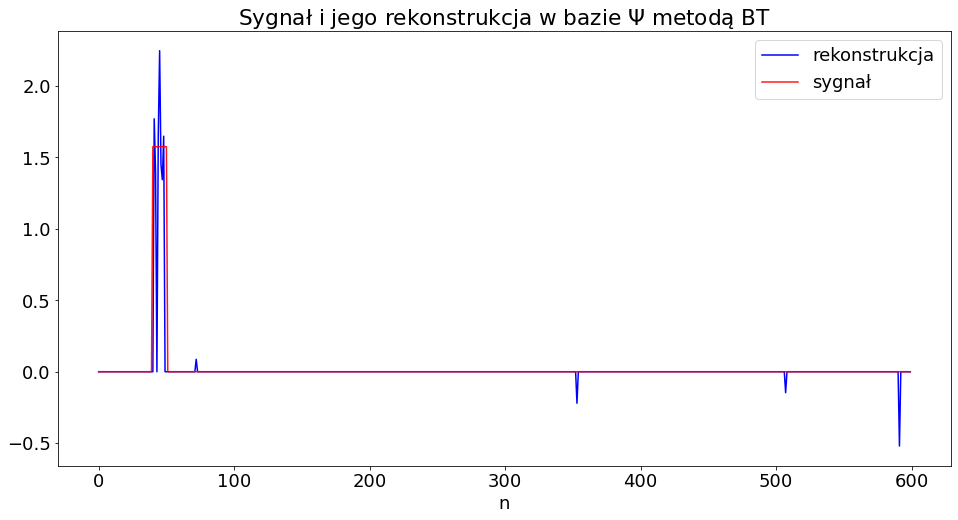

Błąd SSR wynosi: 10.869632656698569


<ipython-input-12-85755cd12f3a>:153: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


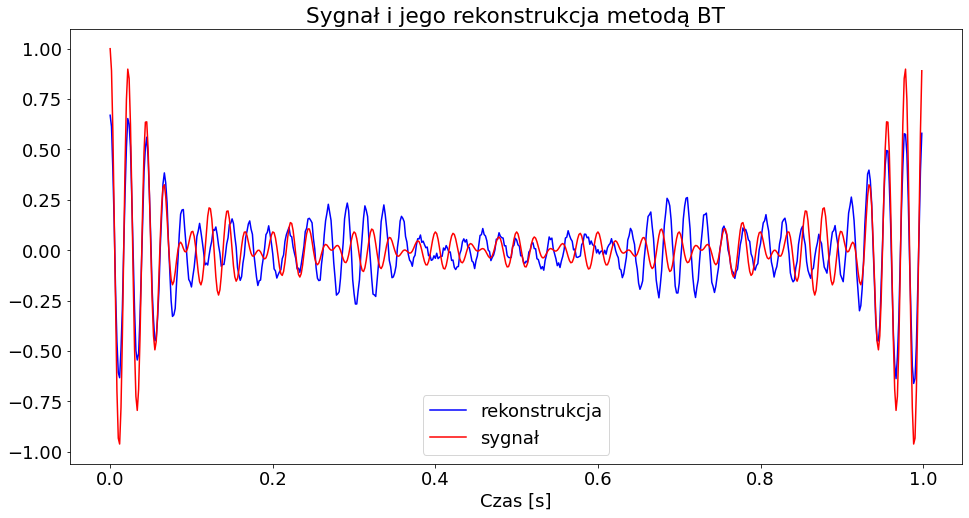

In [12]:
############################################# ALGORYTMY M=80 S=11 ###########################################

plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams.update({'font.size': 18})
t_1 = 1
dt = 1/600
t = np.arange(0, t_1, dt)

x = signal(t, n=11)
Nn = len(t)
B = ONB(x=t, N=Nn)

x_new = B.dot(x)
N = int((1/dt)*t_1)
K = int(np.floor(N/2))

Mm = 80
k = 11

rng = np.random.default_rng(2067)

A = rng.normal(0, 1/np.sqrt(Nn), (Mm, Nn))
A_norm = normalize(A, axis=1, norm="l2")
y = A.dot(x_new)
#print("Norma l_1 dla x_new: {}".format(sum(abs(x_new))))

print("Spójnośc między macierzami: {}".format(float(coherence(A_norm, B))))

################################################## OMP ##################################################

coef = orthogonal_mp(A, y, tol=1e-16)
#print("Norma l_1 dla coef: {}".format(sum(abs(coef))))

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t*600, x_new, c='red', linewidth=3)
ax.plot(t*600, coef, c='black', label='x(t)', linewidth=2, linestyle='dashed', alpha = 0.9)
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą OMP")
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

SSR = (x - B.T.dot(coef))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))
#print(coef.nonzero())

plt.plot(t, x, color = "red", linewidth = 3)
plt.plot(t, B.T.dot(coef), color = "black", linewidth=2, linestyle='dashed', alpha = 0.9)
plt.xlabel('Czas [s]')
plt.title("Sygnał i jego rekonstrukcja metodą OMP")
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

################################################## BP ##################################################

bp = reconstructBP(vec=y, Mat=A, tolerance = 1e-16)
#print("Norma l_1 dla bp: {}".format(sum(abs(bp))))

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t*600, bp, c='blue')
ax.plot(t*600, x_new, c='red')
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą BP")
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()

SSR = (x - B.T.dot(bp))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))

plt.plot(t, B.T.dot(bp), color = "blue")
plt.plot(t, x, color = "red", alpha = 0.9)
plt.xlabel('Czas [s]')
plt.title("Sygnał i jego rekonstrukcja metodą BP")
plt.xlabel('Czas [s]')
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()

################################################## IHT ##################################################

iht = IHT(A, y, s=k, tol = 1e-16)

#print("Norma l_1 dla iht: {}".format(sum(abs(iht))))

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t*600, iht, c='blue', label='x(t)')
ax.plot(t*600, x_new, c='red')
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą IHT")
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()
# print(iht.nonzero())

SSR = (x - B.T.dot(iht))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))

plt.plot(t, B.T.dot(iht), color = "blue")
plt.plot(t, x, color = "red")
plt.xlabel('Czas [s]')
plt.title("Sygnał i jego rekonstrukcja metodą IHT")
plt.xlabel('Czas [s]')
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()

################################################## HTP ##################################################

htp = HTP(A, y, s=k, tol = 1e-16)
#print("Norma l_1 dla bp: {}".format(sum(abs(htp))))

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t*600, x_new, c='red', linewidth=3)
ax.plot(t*600, htp, c='black', label='x(t)', linewidth=2, linestyle='dashed', alpha = 0.9)
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą HTP")
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

SSR = (x - B.T.dot(htp))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))

plt.plot(t, x, color = "red", linewidth = 3)
plt.plot(t, B.T.dot(htp), color = "black", linewidth=2, linestyle='dashed', alpha = 0.9)
plt.xlabel('Czas [s]')
plt.title("Sygnał i jego rekonstrukcja metodą HTP")
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

################################################## BT ##################################################

bt = reconstructBT(A, y, s=k, tolerance = 1e-16)

# print("Norma l_1 dla bt: {}".format(sum(abs(bt))))

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t*600, bt, c='blue', label='x(t)')
ax.plot(t*600, x_new, c='red', alpha = 0.9)
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą BT")
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()

SSR = (x - B.T.dot(bt))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))

plt.plot(t, B.T.dot(bt), color = "blue")
plt.plot(t, x, color = "red")
plt.xlabel('Czas [s]')
plt.title("Sygnał i jego rekonstrukcja metodą BT")
plt.xlabel('Czas [s]')
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()

zero, = bt.nonzero()

# print(zero)
# print(bt[zero])

<ipython-input-13-ad8f07019462>:35: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


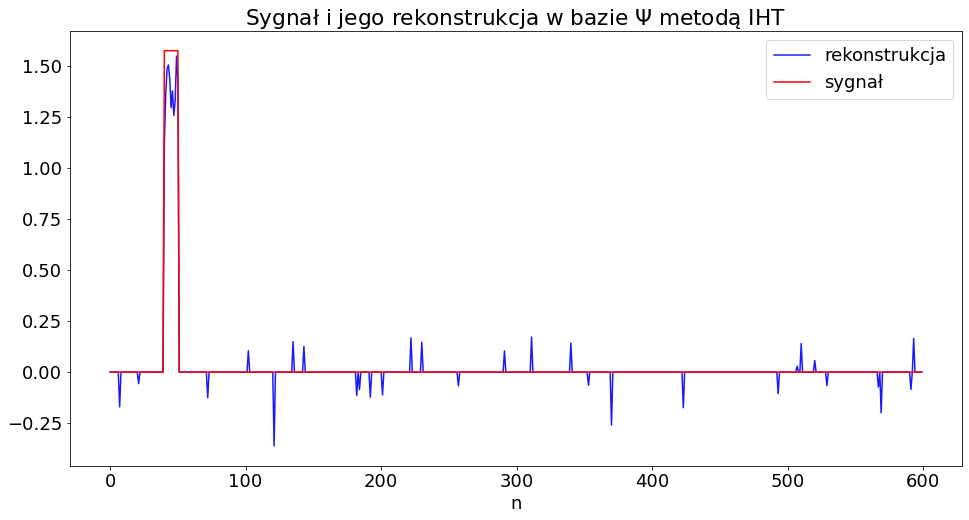

Błąd SSR wynosi: 1.192935310884825


<ipython-input-13-ad8f07019462>:46: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


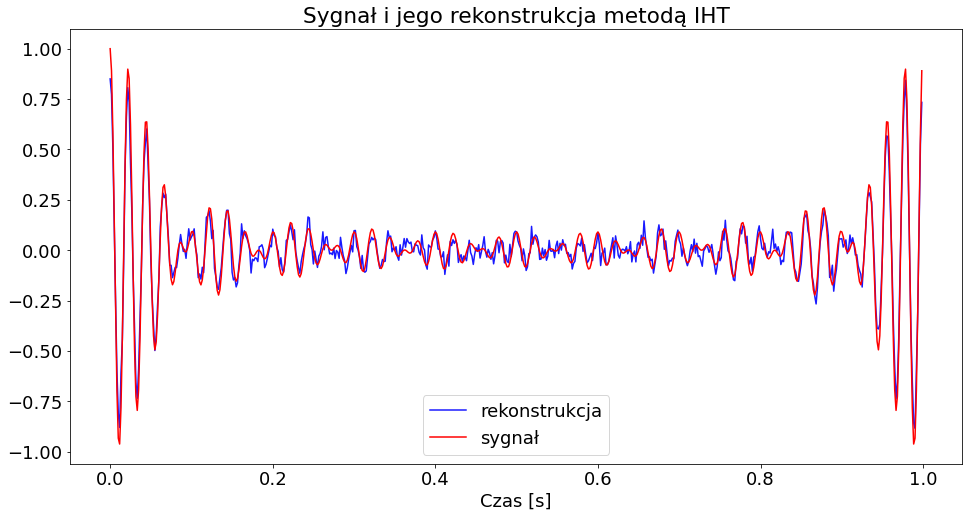

<ipython-input-13-ad8f07019462>:60: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


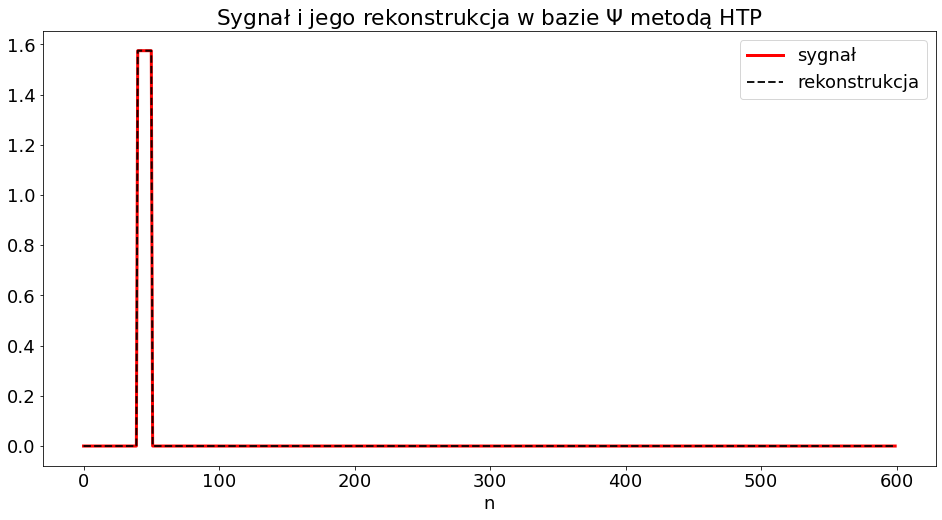

Błąd SSR wynosi: 5.2054139556306795e-14


<ipython-input-13-ad8f07019462>:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])


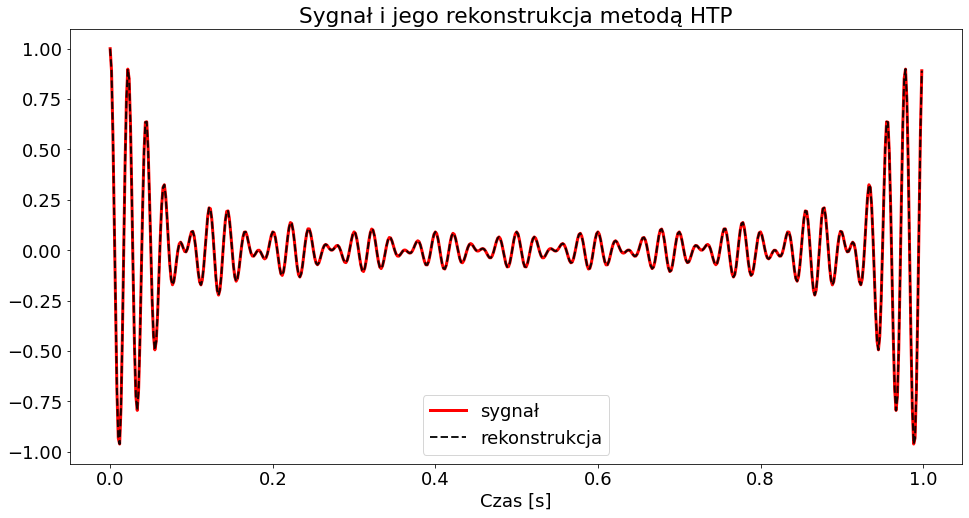

<ipython-input-13-ad8f07019462>:85: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


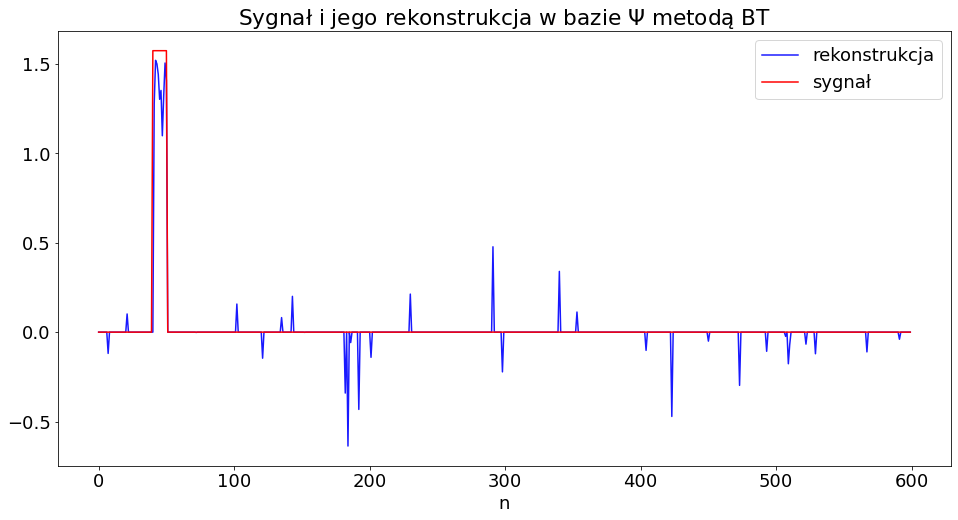

Błąd SSR wynosi: 4.747003544177981


<ipython-input-13-ad8f07019462>:95: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])


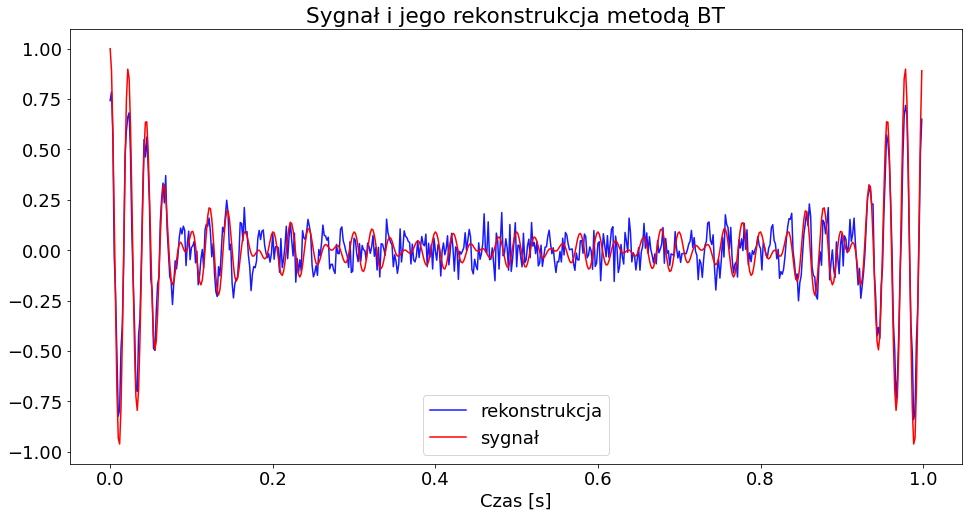

In [13]:
############################################# ALGORYTMY M=80 S=40 ###########################################

plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams.update({'font.size': 18})
t_1 = 1
dt = 1/600
t = np.arange(0, t_1, dt)

x = signal(t, n=11)
Nn = len(t)
B = ONB(x=t, N=Nn)

x_new = B.dot(x)
N = int((1/dt)*t_1)
K = int(np.floor(N/2))

Mm = 80
k = 40

rng = np.random.default_rng(2067)

A = rng.normal(0, 1/np.sqrt(Nn), (Mm, Nn))
y = A.dot(x_new)

##################################################### IHT ###########################################

iht = IHT(A, y, s=k, tol = 1e-16)

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t*600, iht, c='blue', label='x(t)', alpha = 0.9)
ax.plot(t*600, x_new, c='red')
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą IHT")
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()
# print(iht.nonzero())

SSR = (x - B.T.dot(iht))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))

plt.plot(t, B.T.dot(iht), color = "blue", alpha = 0.9)
plt.plot(t, x, color = "red")
plt.xlabel('Czas [s]')
plt.title("Sygnał i jego rekonstrukcja metodą IHT")
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()

##################################################### HTP ###########################################

htp = HTP(A, y, s=k, tol = 1e-16)
# print("Norma l_1 dla bp: {}".format(sum(abs(htp))))

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t*600, x_new, c='red', linewidth=3)
ax.plot(t*600, htp, c='black', label='x(t)', linewidth=2, linestyle='dashed', alpha = 0.9)
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą HTP")
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

SSR = (x - B.T.dot(htp))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))

plt.plot(t, x, color = "red", linewidth = 3)
plt.plot(t, B.T.dot(htp), color = "black", linewidth=2, linestyle='dashed', alpha = 0.9)
plt.xlabel('Czas [s]')
plt.title("Sygnał i jego rekonstrukcja metodą HTP")
plt.legend([1,2], labels=["sygnał", "rekonstrukcja"])
plt.show()

##################################################### BT ###########################################

bt = reconstructBT(A, y, s=k, tolerance = 1e-16)

# print("Norma l_1 dla bt: {}".format(sum(abs(bt))))

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t*600, bt, c='blue', label='x(t)', alpha = 0.9)
ax.plot(t*600, x_new, c='red')
plt.xlabel('n')
plt.title(r"Sygnał i jego rekonstrukcja w bazie $\Psi$ metodą BT")
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()

SSR = (x - B.T.dot(bt))**2
print("Błąd SSR wynosi: {}".format(sum(SSR)))

plt.plot(t, B.T.dot(bt), color = "blue", alpha = 0.9)
plt.plot(t, x, color = "red")
plt.xlabel('Czas [s]')
plt.title("Sygnał i jego rekonstrukcja metodą BT")
plt.legend([1,2], labels=["rekonstrukcja", "sygnał"])
plt.show()

# print(bt.nonzero())